In [95]:
library(readr)
library(dplyr)
library(stringr)
library(lfe)
library(ggsci)
library(lubridate)
library(ggplot2)
library(doMC)
library(gridExtra)
library(ggpubr)
library(stargazer)
registerDoMC(4)

In [4]:
fp <- '/pool001/mfzhao/'
df <- read_rds(str_c(fp, '/PROCESSED_DATA/panel_xgr.RDS'))

In [5]:
cns <- colnames(df)
cns

[1] "key"                    "date"                   "n"                     
 [4] "cluster"                "fold"                   "mcbgv.r"               
 [7] "pnchd.r"                "pgt1hafh.r"             "ppthlt75.r"            
[10] "pgt2kmt.r"              "p1sdp.r"                "p2shp.r"               
[13] "p3rop.r"                "p1sdpDSS.r"             "p2shpDSS.r"            
[16] "p3ropDSS.r"             "stalter_mcbgv.r"        "stalter_pnchd.r"       
[19] "stalter_pgt1hafh.r"     "stalter_ppthlt75.r"     "stalter_pgt2kmt.r"     
[22] "stalter_p1sdp.r"        "stalter_p2shp.r"        "stalter_p3rop.r"       
[25] "stalter_p1sdpDSS.r"     "stalter_p2shpDSS.r"     "stalter_p3ropDSS.r"    
[28] "stalter_prcp01.r"       "stalter_prcp02.r"       "stalter_prcp03.r"      
[31] "stalter_prcp04.r"       "stalter_prcp05.r"       "stalter_prcp06.r"      
[34] "stalter_prcp07.r"       "stalter_prcp08.r"       "stalter_prcp09.r"      
[37] "stalter_prcp10.r"       "stalter_tmax02.r"       "stalter_tmax03.r"      
[40] "stalter_tmax04.r"       "stalter_tmax05.r"       "stalter_tmax06.r"      
[43] "stalter_tmax07.r"       "stalter_tmax08.r"       "stalter_tmax09.r"      
[46] "stalter_tmax10.r"       "alter_mcbgv.r"          "alter_pnchd.r"         
[49] "alter_pgt1hafh.r"       "alter_ppthlt75.r"       "alter_pgt2kmt.r"       
[52] "alter_p1sdp.r"          "alter_p2shp.r"          "alter_p3rop.r"         
[55] "alter_p1sdpDSS.r"       "alter_p2shpDSS.r"       "alter_p3ropDSS.r"      
[58] "alter_prcp01.r"         "alter_prcp02.r"         "alter_prcp03.r"        
[61] "alter_prcp04.r"         "alter_prcp05.r"         "alter_prcp06.r"        
[64] "alter_prcp07.r"         "alter_prcp08.r"         "alter_prcp09.r"        
[67] "alter_prcp10.r"         "alter_tmax02.r"         "alter_tmax03.r"        
[70] "alter_tmax04.r"         "alter_tmax05.r"         "alter_tmax06.r"        
[73] "alter_tmax07.r"         "alter_tmax08.r"         "alter_tmax09.r"        
[76] "alter_tmax10.r"         "log_mcbgv.r"            "log_pnchd.r"           
[79] "log_pgt1hafh.r"         "log_ppthlt75.r"         "log_pgt2kmt.r"         
[82] "log_stalter_mcbgv.r"    "log_stalter_pnchd.r"    "log_stalter_pgt1hafh.r"
[85] "log_stalter_ppthlt75.r" "log_stalter_pgt2kmt.r"  "log_alter_mcbgv.r"     
[88] "log_alter_pnchd.r"      "log_alter_pgt1hafh.r"   "log_alter_ppthlt75.r"  
[91] "log_alter_pgt2kmt.r"

In [6]:
ldvs <- c('log_mcbgv.r', 'log_pgt2kmt.r', 'log_pgt1hafh.r', 'log_pnchd.r')
dvs  <- c('mcbgv.r', 'pnchd.r', 'pgt1hafh.r', 'pgt2kmt.r')

In [13]:
get_coefs <- function(dv, vars, ivmod = F, ...) {
    lhs <- str_c(dv, ' ~ ')
    rhs <- str_c(vars, '| key + date | ')

    if(ivmod == T) {
        alter_weather <- str_c(cns[str_detect(cns, '^stalter_[pt][rm][ca][px][01][0-9]\\.r$')], collapse = ' + ')
        iv <- ifelse(str_detect(dv, 'log'), str_replace(dv, 'log', 'log_stalter'), str_c('alter_', dv))
        ivf <- str_c('(', iv, ' ~ ', alter_weather, ') | cluster')
        rhs <- str_c(rhs, ivf)
    } else {
        rhs <- str_c(rhs, '0 | cluster')
    }
    form <- as.formula(str_c(lhs, rhs))
    model <- felm(form, df, weights = df$n, ...)
    
    as.data.frame(summary(model)$coef) %>%
        mutate(var   = rownames(.),
               dv    = dv,
               model = ifelse(vars == f1, 'base', 'ap'),
               model = ifelse(ivmod, str_c(model, ' + iv'), model)) %>%
        filter(!str_detect(var, '[pPtT][rRmM][cCaA][pPxX]')) %>%
        select(7, 6, 5, 1, 2, 3, 4) -> out
    
    colnames(out) <- c('model', 'dv', 'var', 'estimate', 'se', 't', 'p-val')
    return(out)
}

In [14]:
f1 <- ' p1sdp.r + p2shp.r + p3rop.r '  
f2 <- ' p1sdp.r + p2shp.r + p3rop.r + stalter_p1sdp.r + stalter_p2shp.r + stalter_p3rop.r '

In [15]:
foreach(dv = ldvs, .combine = rbind) %:% 
    foreach(f = c(f1, f2), .combine = rbind) %:%
    foreach(ivmod = c(F, T), .combine = rbind) %dopar%
    get_coefs(dv, f, ivmod) -> coefs

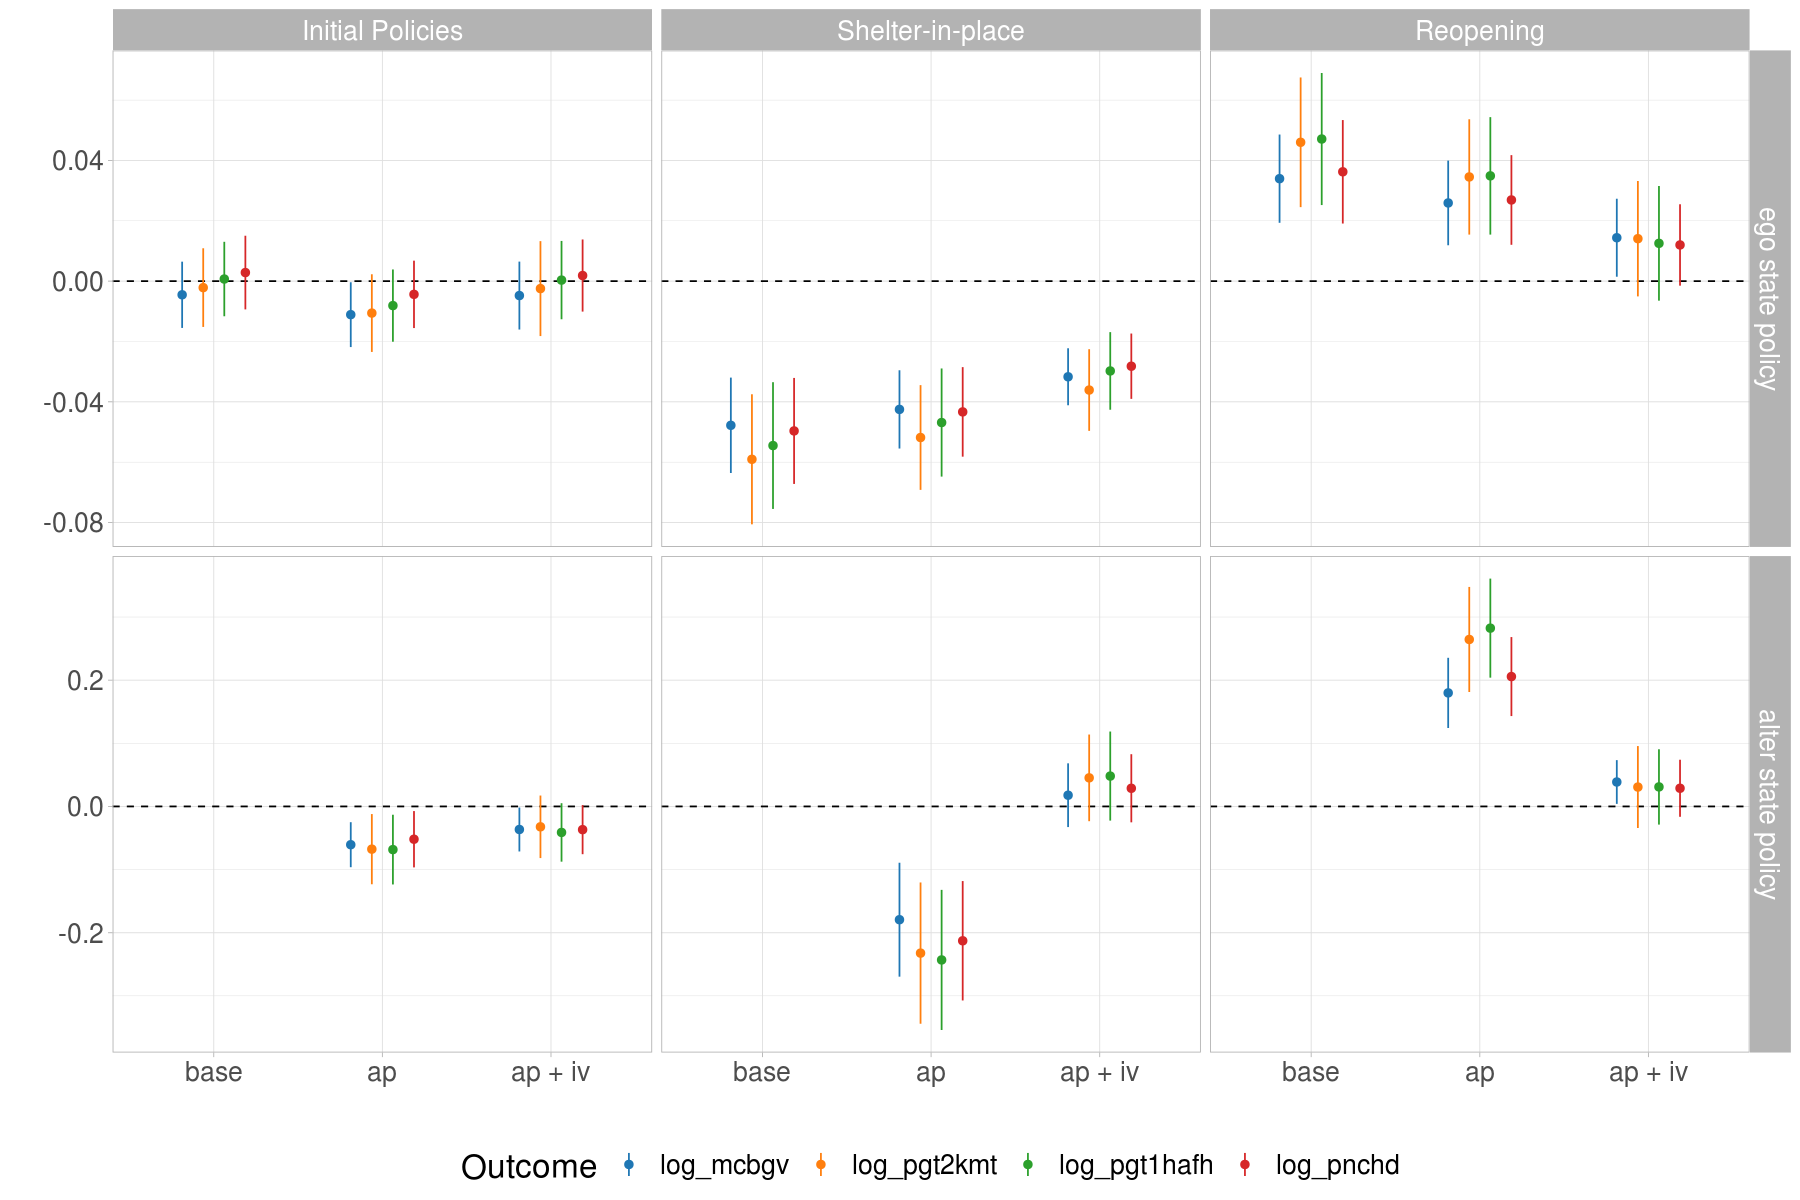

In [63]:
options(repr.plot.width=15, repr.plot.height=10)
pn <- c('p1sdp' = "Initial Policies",
        'p2shp' = "Shelter-in-place",
        'p3rop' = "Reopening",
        'a'     = 'ego state policy',
        'b'     = 'alter state policy')

coefs %>%
    mutate(dv  = str_replace(dv, '\\.r', ''),
           var = str_replace(var, '\\.r', ''),
           var = ifelse(str_detect(var, 'fit'), 'Peer Effect', var)) %>%
    filter(var != 'Peer Effect') %>%
    filter(model != 'base + iv') %>%
    mutate(vtype = ifelse(str_detect(var, 'stalter'), 'b', 'a'),
           var   = str_replace(var, 'stalter_', ''),
           model = factor(model, levels = c('base', 'base + iv', 'ap', 'ap + iv')),
           dv = factor(dv, levels = c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd'))) %>%
    ggplot(aes(x = model, y = estimate, color = dv)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(width = .5), size = 2) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), 
                   position = position_dodge(width = .5), size = .5) +
    facet_grid(vtype~var, scales = 'free_y', labeller = as_labeller(pn)) +
    xlab('') + 
    ylab('') +
    scale_color_d3() +
    labs(color = "Outcome") +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom') -> p2a

ggsave('/home/mfzhao/p2.svg', p2a, device = 'svg', width = 4.5, height = 5, scale = 2)
p2a

In [91]:
get_models <- function(dv, vars, ivmod = F, ...) {
    lhs <- str_c(dv, ' ~ ')
    rhs <- str_c(vars, '| key + date | ')

    if(ivmod == T) {
        alter_weather <- str_c(cns[str_detect(cns, '^stalter_[pt][rm][ca][px][01][0-9]\\.r$')], collapse = ' + ')
        iv <- ifelse(str_detect(dv, 'log'), str_replace(dv, 'log', 'log_stalter'), str_c('stalter_', dv))
        ivf <- str_c('(', iv, ' ~ ', alter_weather, ') | cluster')
        rhs <- str_c(rhs, ivf)
    } else {
        rhs <- str_c(rhs, '0 | cluster')
    }
    form <- as.formula(str_c(lhs, rhs))
    model <- felm(form, df, weights = df$n, ...)
    
    return(model)
}

In [53]:
foreach(dv = ldvs) %dopar% get_models(dv, f1, F) -> models_base

In [55]:
stargazer(models_base)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Thu, Aug 06, 2020 - 10:06:18 PM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & log\_mcbgv.r & log\_pgt2kmt.r & log\_pgt1hafh.r & log\_pnchd.r \\ 
\\[-1.8ex] & (1) & (2) & (3) & (4)\\ 
\hline \\[-1.8ex] 
 p1sdp.r & $-$0.005 & $-$0.002 & 0.001 & 0.003 \\ 
  & (0.006) & (0.007) & (0.006) & (0.006) \\ 
  & & & & \\ 
 p2shp.r & $-$0.048$^{***}$ & $-$0.059$^{***}$ & $-$0.055$^{***}$ & $-$0.050$^{***}$ \\ 
  & (0.008) & (0.011) & (0.011) & (0.009) \\ 
  & & & & \\ 
 p3rop.r & 0.034$^{***}$ & 0.046$^{***}$ & 0.047$^{***}$ & 0.036$^{***}$ \\ 
  & (0.007) & (0.011) & (0.011) & (0.009) \\ 
  & & & & \\ 
\hline \\[-1.8ex] 
Observations & 470,106 & 470,106 & 470,106 & 470,106 \\ 
R$^{2}$ & 0.049 & 0.043

In [56]:
foreach(dv = ldvs) %dopar% get_models(dv, f2, F) -> models_ap

In [57]:
stargazer(models_ap)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Thu, Aug 06, 2020 - 10:13:04 PM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & log\_mcbgv.r & log\_pgt2kmt.r & log\_pgt1hafh.r & log\_pnchd.r \\ 
\\[-1.8ex] & (1) & (2) & (3) & (4)\\ 
\hline \\[-1.8ex] 
 p1sdp.r & $-$0.011$^{**}$ & $-$0.011 & $-$0.008 & $-$0.004 \\ 
  & (0.005) & (0.006) & (0.006) & (0.006) \\ 
  & & & & \\ 
 p2shp.r & $-$0.043$^{***}$ & $-$0.052$^{***}$ & $-$0.047$^{***}$ & $-$0.043$^{***}$ \\ 
  & (0.007) & (0.009) & (0.009) & (0.007) \\ 
  & & & & \\ 
 p3rop.r & 0.026$^{***}$ & 0.035$^{***}$ & 0.035$^{***}$ & 0.027$^{***}$ \\ 
  & (0.007) & (0.010) & (0.010) & (0.008) \\ 
  & & & & \\ 
 stalter\_p1sdp.r & $-$0.061$^{***}$ & $-$0.068$^{**}$ & $-$0.068$^{**}$ & $-$0.052$^{

In [92]:
foreach(dv = ldvs) %dopar% get_models(dv, f2, T) -> models_apiv

In [93]:
stargazer(models_apiv)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Fri, Aug 07, 2020 - 03:09:56 AM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & log\_mcbgv.r & log\_pgt2kmt.r & log\_pgt1hafh.r & log\_pnchd.r \\ 
\\[-1.8ex] & (1) & (2) & (3) & (4)\\ 
\hline \\[-1.8ex] 
 p1sdp.r & $-$0.005 & $-$0.002 & 0.0003 & 0.002 \\ 
  & (0.006) & (0.008) & (0.007) & (0.006) \\ 
  & & & & \\ 
 p2shp.r & $-$0.032$^{***}$ & $-$0.036$^{***}$ & $-$0.030$^{***}$ & $-$0.028$^{***}$ \\ 
  & (0.005) & (0.007) & (0.006) & (0.005) \\ 
  & & & & \\ 
 p3rop.r & 0.014$^{**}$ & 0.014 & 0.013 & 0.012$^{*}$ \\ 
  & (0.007) & (0.010) & (0.010) & (0.007) \\ 
  & & & & \\ 
 stalter\_p1sdp.r & $-$0.037$^{**}$ & $-$0.032 & $-$0.041$^{*}$ & $-$0.037$^{*}$ \\ 
  & (0.018) & (0.025) & (0.023) 

In [94]:
condfstat(models_apiv[[1]])
condfstat(models_apiv[[2]])
condfstat(models_apiv[[3]])
condfstat(models_apiv[[4]])

,log_stalter_mcbgv.r
cluster F,71.87942


,log_stalter_pgt2kmt.r
cluster F,60.89547


,log_stalter_pgt1hafh.r
cluster F,62.58004


,log_stalter_pnchd.r
cluster F,72.42997


In [95]:
foreach(dv = ldvs) %dopar% get_models(dv, f2, T, kclass = 'liml') -> models_apiv_liml

In [96]:
stargazer(models_apiv_liml)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Fri, Aug 07, 2020 - 03:10:08 AM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & log\_mcbgv.r & log\_pgt2kmt.r & log\_pgt1hafh.r & log\_pnchd.r \\ 
\\[-1.8ex] & (1) & (2) & (3) & (4)\\ 
\hline \\[-1.8ex] 
 p1sdp.r & $-$0.002 & $-$0.001 & 0.002 & 0.004 \\ 
  & (0.006) & (0.008) & (0.007) & (0.006) \\ 
  & & & & \\ 
 p2shp.r & $-$0.027$^{***}$ & $-$0.032$^{***}$ & $-$0.025$^{***}$ & $-$0.024$^{***}$ \\ 
  & (0.005) & (0.008) & (0.007) & (0.006) \\ 
  & & & & \\ 
 p3rop.r & 0.009 & 0.009 & 0.007 & 0.007 \\ 
  & (0.007) & (0.010) & (0.010) & (0.007) \\ 
  & & & & \\ 
 stalter\_p1sdp.r & $-$0.026 & $-$0.024 & $-$0.034 & $-$0.032 \\ 
  & (0.019) & (0.027) & (0.025) & (0.021) \\ 
  & & & & \\ 
 stal

In [18]:
coefs %>%
    mutate(dv  = str_replace(dv, '\\.r', ''),
           var = str_replace(var, '\\.r', ''),
           var = ifelse(str_detect(var, 'fit'), 'Peer Effect', var)) %>%
    filter(model == 'ap + iv') -> apiv
    

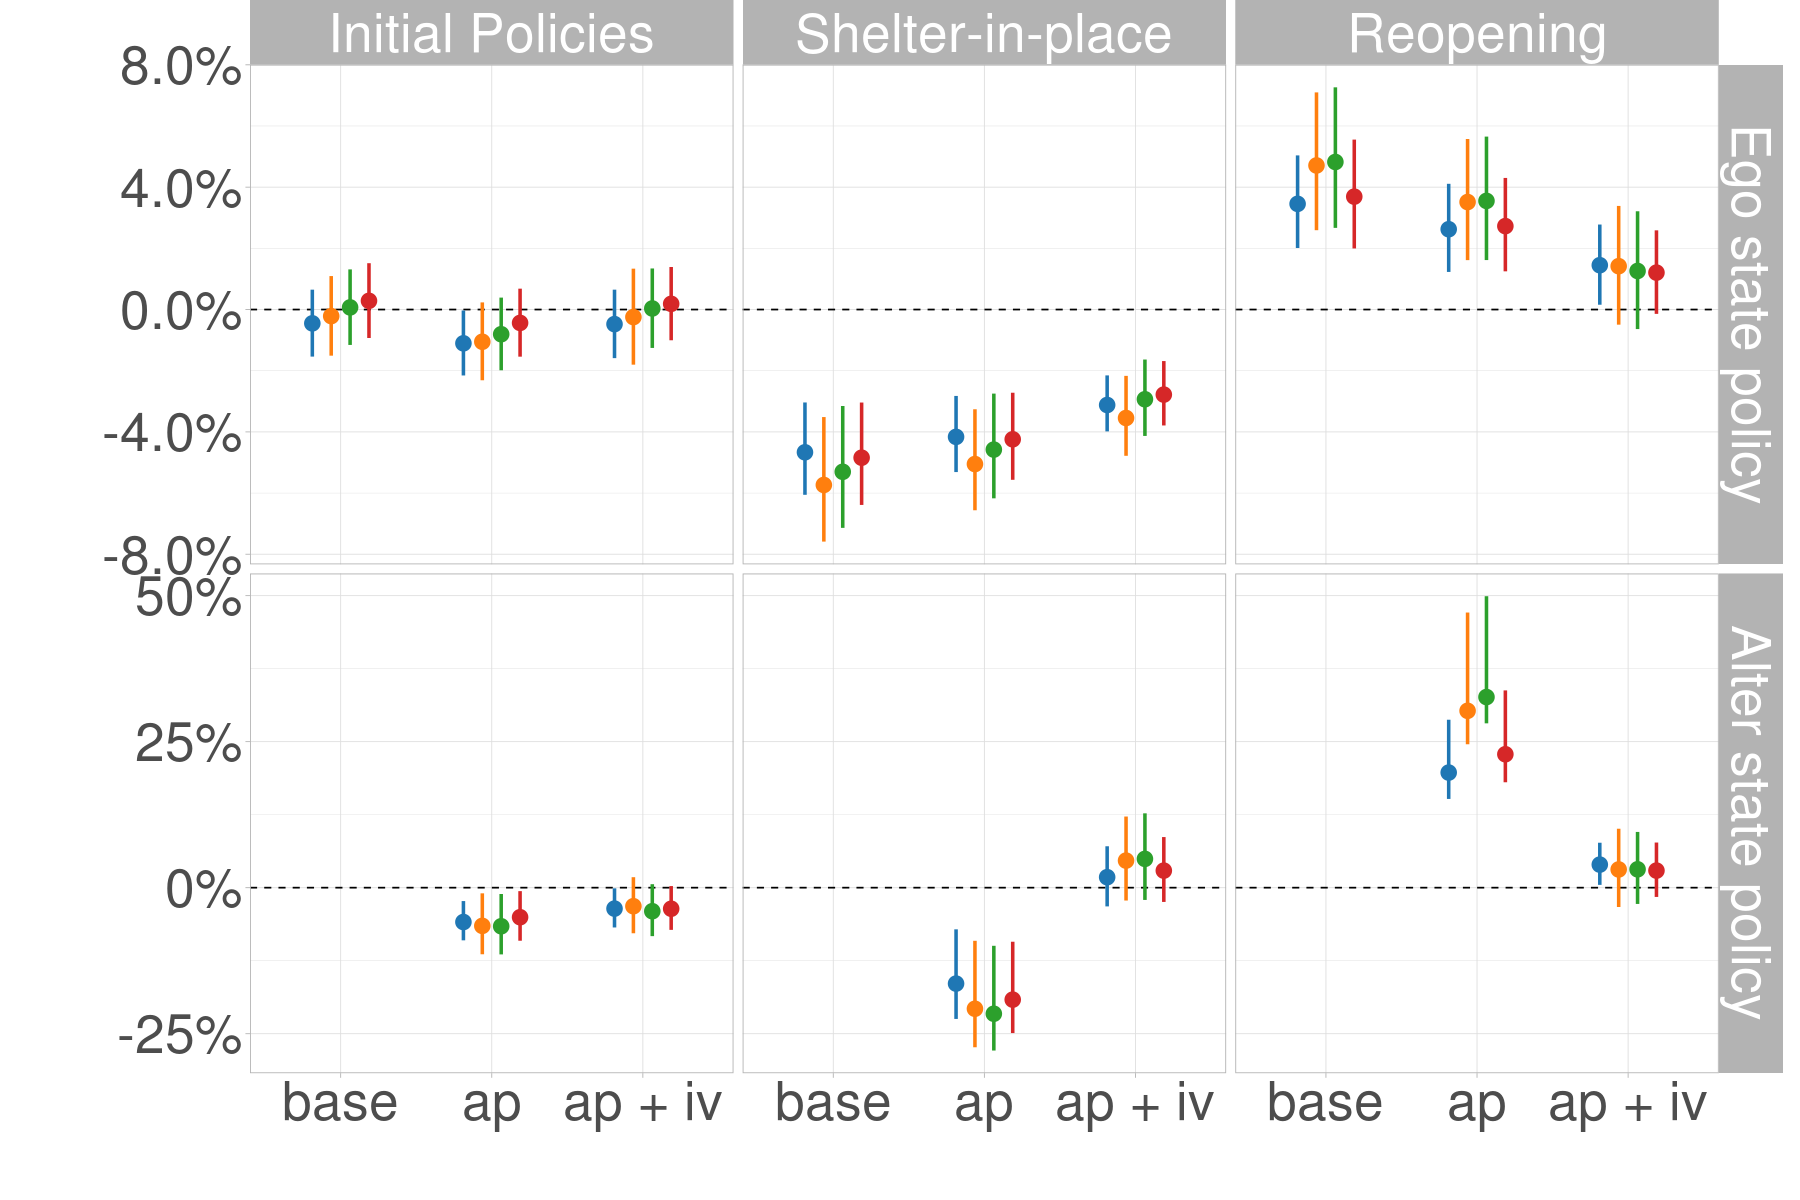

In [244]:
options(repr.plot.width=15, repr.plot.height=10)
pn <- c('p1sdp' = "Initial Policies",
        'p2shp' = "Shelter-in-place",
        'p3rop' = "Reopening",
        'a'     = 'Ego state policy',
        'b'     = 'Alter state policy')

coefs %>%
    mutate(dv  = str_replace(dv, '\\.r', ''),
           var = str_replace(var, '\\.r', ''),
           var = ifelse(str_detect(var, 'fit'), 'Peer Effect', var),
           estimate = exp(estimate) - 1,
           u95ci    = exp(estimate + 1.98 * se) - 1,
           l95ci    = exp(estimate - 1.98 * se) - 1) %>%
    filter(var != 'Peer Effect') %>%
    filter(model != 'base + iv') %>%
    mutate(vtype = ifelse(str_detect(var, 'stalter'), 'b', 'a'),
           var   = str_replace(var, 'stalter_', ''),
           model = factor(model, levels = c('base', 'base + iv', 'ap', 'ap + iv')),
           dv = factor(dv, levels = c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd'))) %>%
    ggplot(aes(x = model, y = estimate, color = dv)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(width = .5), size = 4) + 
    geom_linerange(aes(ymin = l95ci, ymax = u95ci), 
                   position = position_dodge(width = .5), size = 1) +
    facet_grid(vtype~var, scales = 'free_y', labeller = as_labeller(pn)) +
    scale_y_continuous(labels = scales::percent) +
    xlab('') + 
    ylab('') +
    scale_color_d3() +
    labs(color = "Outcome") +
    theme_light() +
    theme(text = element_text(size=40),
          legend.position = 'None',
          plot.margin = margin(0, 10, 0, 20)) -> p2a


ggsave('/home/mfzhao/p2a.svg', p2a, device = 'svg', width = 9, height = 10, scale = 2)
p2a

Joining, by = "dv"



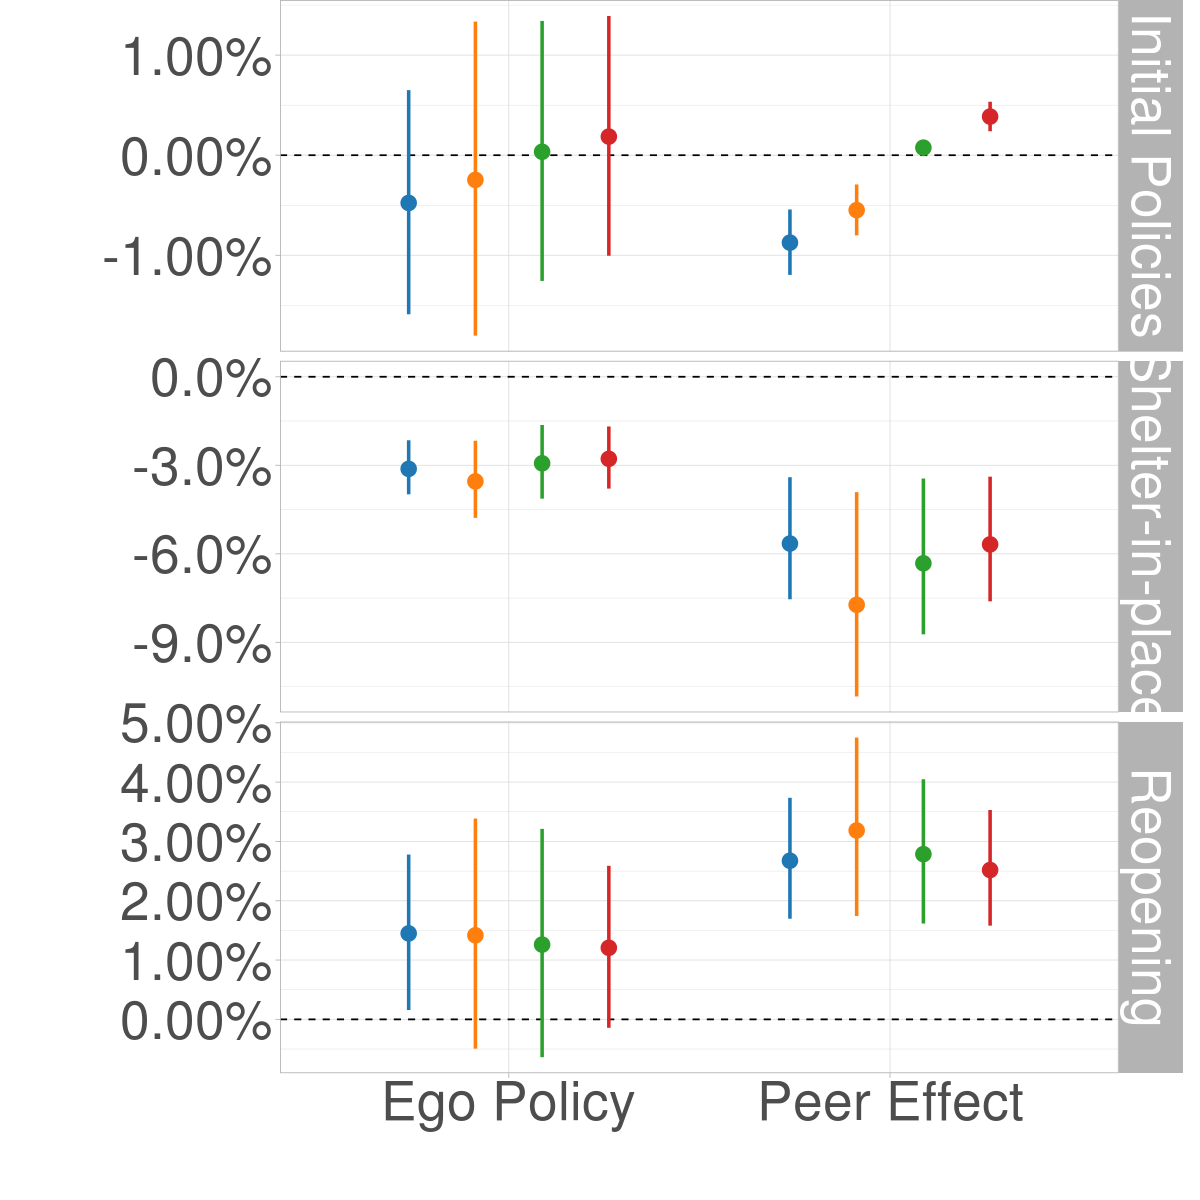

In [245]:
options(repr.plot.width=10, repr.plot.height=10)
apiv %>%
    filter(var == 'Peer Effect') %>%
    select(dv, pfxCoef = estimate, pfxSe = se) %>%
    left_join(apiv %>%
              filter(!str_detect(var, 'stalter'),
                     var != 'Peer Effect')) %>%
    mutate(estimate = estimate * pfxCoef,
           se       = estimate * pfxSe,
           var      = str_c('pfx_', var)) %>%
    select(model, dv, var, estimate, se, t, `p-val`) %>%
    bind_rows(apiv %>%
              filter(var != 'Peer Effect',
                     !str_detect(var, 'stalter'))) %>%
    mutate(policy = str_sub(var, -5, -1),
           type   = ifelse(str_detect(var, 'pfx'), 'Peer Effect',
                           ifelse(str_detect(var, 'stalter'), 'Alter Policy', 'Ego Policy')),
           dv = factor(dv, levels = c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd')),
           estimate = exp(estimate) - 1,
           u95ci    = exp(estimate + 1.98 * se) - 1,
           l95ci    = exp(estimate - 1.98 * se) - 1) %>%
    ggplot(aes(x = type, y = estimate, color = dv)) + 
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(width = .7), size = 4) + 
    geom_linerange(aes(ymin = l95ci, ymax =u95ci), 
                   position = position_dodge(width = .7), size = 1) +
    facet_grid(policy~., scales = 'free_y', labeller = as_labeller(pn)) +
    xlab('') + 
    ylab('') +
    scale_color_d3() +
    labs(color = "Outcome") +
    scale_y_continuous(labels = scales::percent) +
    theme_light() +
    theme(text = element_text(size=40),
          legend.position = 'None', 
          plot.margin = margin(0, 10, 0, 20)) -> p2b

p2b
ggsave('/home/mfzhao/p2b.svg', p2b, device = 'svg', width = 4, height = 10, scale = 2)

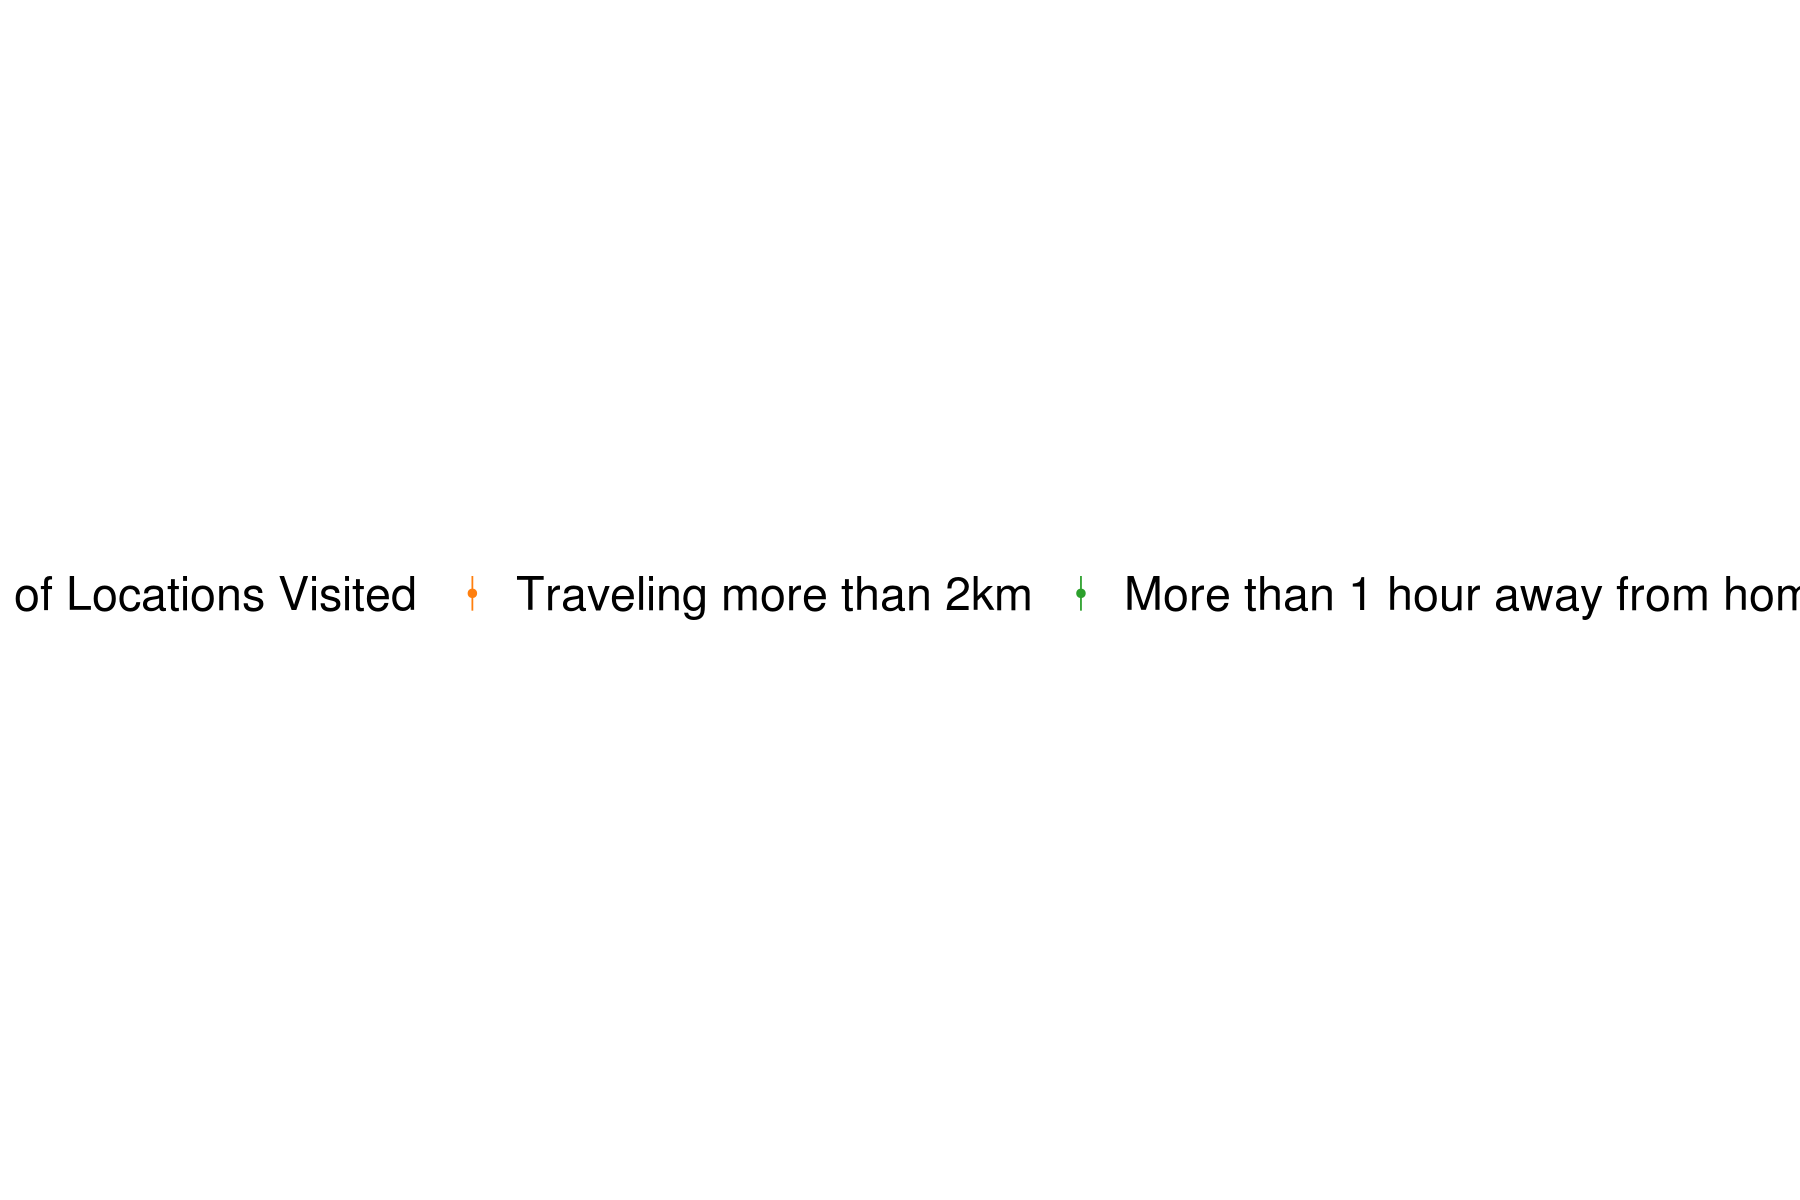

In [242]:
options(repr.plot.width=15, repr.plot.height=10)
pn <- c('p1sdp' = "Initial Policies",
        'p2shp' = "Shelter-in-place",
        'p3rop' = "Reopening",
        'a'     = 'ego state policy',
        'b'     = 'alter state policy')

coefs %>%
    mutate(dv  = str_replace(dv, '\\.r', ''),
           var = str_replace(var, '\\.r', ''),
           var = ifelse(str_detect(var, 'fit'), 'Peer Effect', var)) %>%
    filter(var != 'Peer Effect') %>%
    filter(model != 'base + iv') %>%
    mutate(vtype = ifelse(str_detect(var, 'stalter'), 'b', 'a'),
           var   = str_replace(var, 'stalter_', ''),
           model = factor(model, levels = c('base', 'base + iv', 'ap', 'ap + iv')),
           dv = factor(dv, levels = c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd'))) %>%
    ggplot(aes(x = model, y = estimate, color = dv)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(width = .7), size = 2) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), 
                   position = position_dodge(width = .7), size = .5) +
    facet_grid(vtype~var, scales = 'free_y', labeller = as_labeller(pn)) +
    xlab('') + 
    ylab('') +
    scale_color_d3(labels = c('Average Number of Locations Visited', 
                              'Traveling more than 2km', 
                              'More than 1 hour away from home',
                              'Leaving Home')) +
    labs(color = "") +
    theme_light() +
    theme(text = element_text(size=35),
          legend.position = 'bottom') -> leg


get_legend(leg) %>%
    as_ggplot() -> leg

leg
ggsave('/home/mfzhao/p2leg.svg', leg, device = 'svg', width = 13, height = .25, scale = 2)

In [208]:
p2a + theme(plot.title = element_text(hjust = -0.05, vjust = -1)) -> p2a
p2b + theme(plot.title = element_text(hjust = -0.05, vjust = -1)) -> p2b

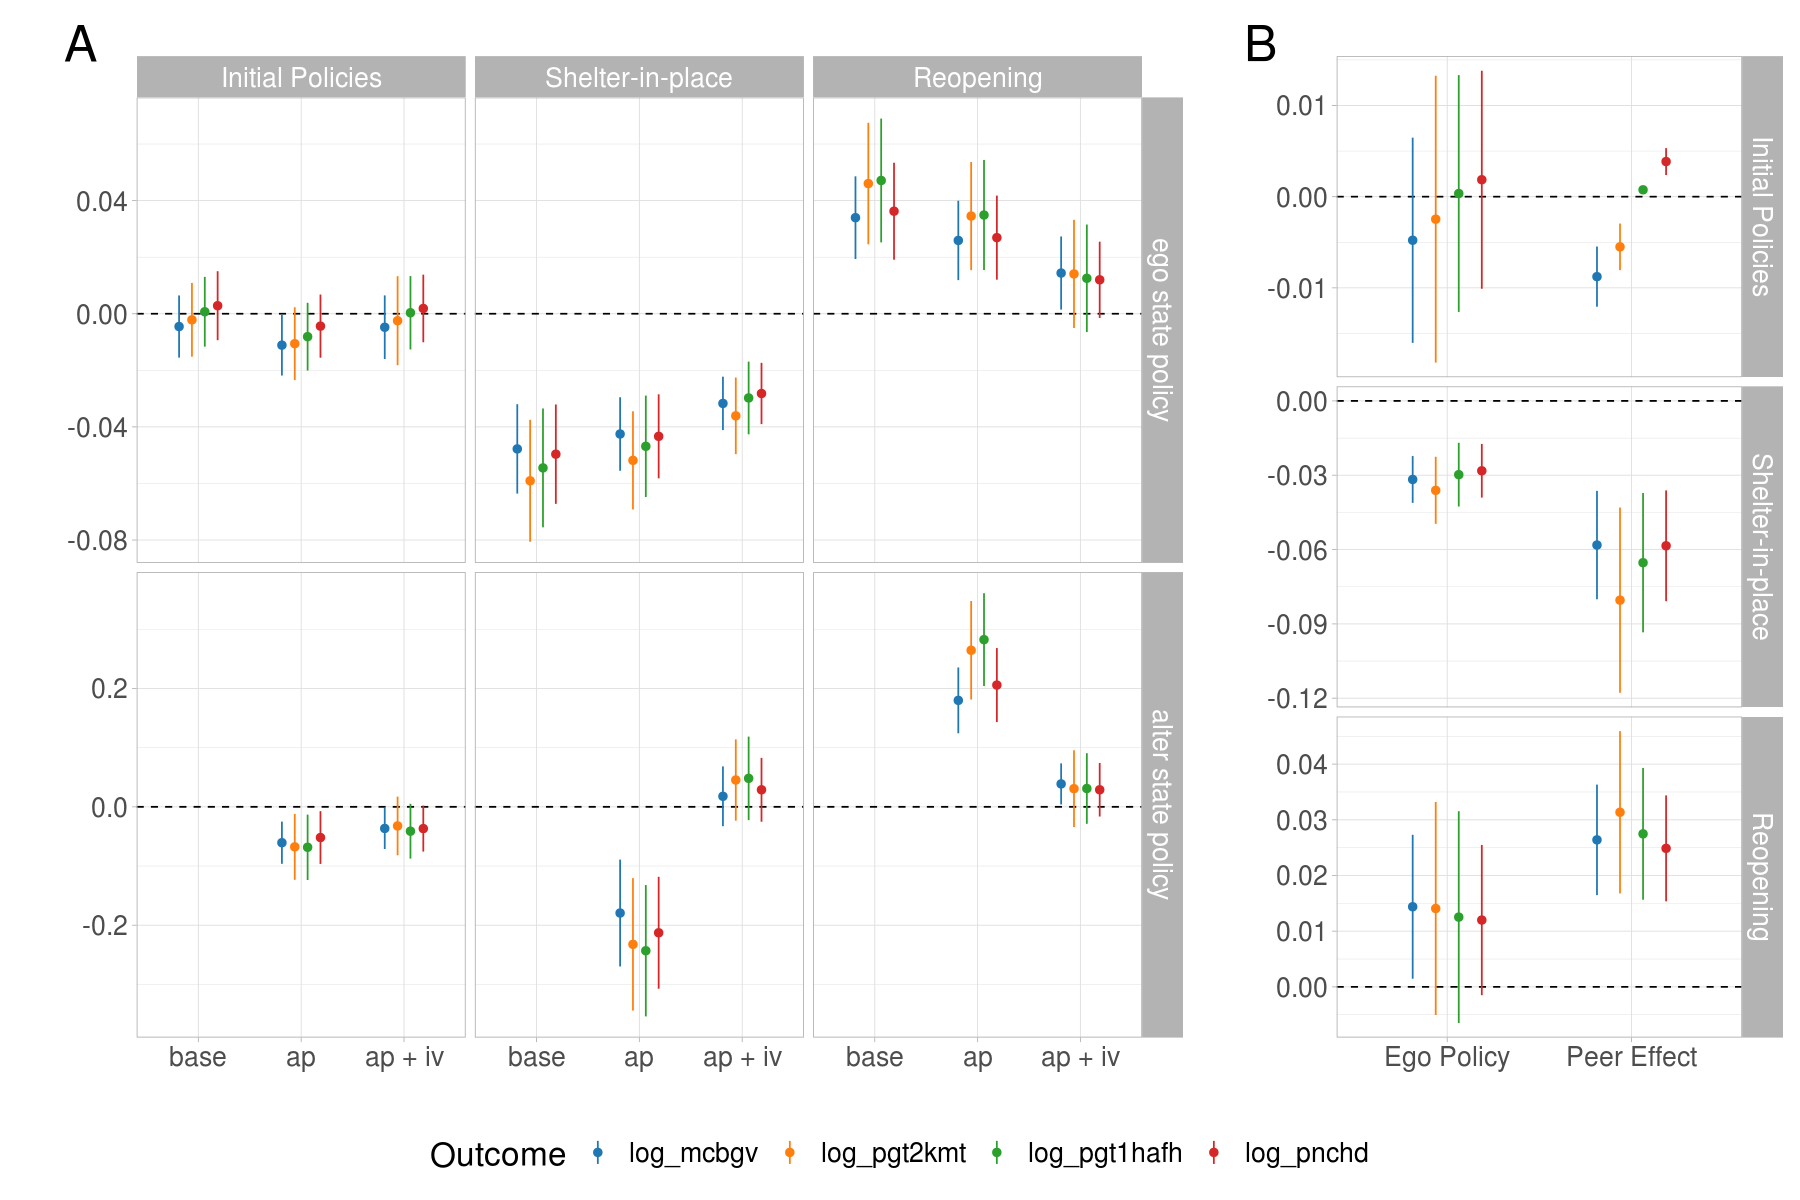

In [209]:
p2a + theme(plot.title = element_text(size = 30, hjust = -0.075, vjust = -1.5)) -> p2a
p2b + theme(plot.title = element_text(size = 30, hjust = -0.25, vjust = -1.5)) -> p2b
lay <- rbind(c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             rep(3, 24))
grid.arrange(grobs = list(p2a, p2b, leg), layout_matrix = lay) -> p2

ggsave('/home/mfzhao/p2.pdf', p2, device = 'pdf', width = 6.5, height = 5, scale = 2)

In [210]:
ggsave('/home/mfzhao/p2.pdf', p2, device = 'pdf', width = 6.5, height = 5, scale = 2)

In [215]:
ggsave('/home/mfzhao/p2leg.svg', leg, device = 'svg', width = 6.5, height = 5, scale = 2)